# Importance Sampling for OTM Options

<b> YouTube Tutorial </b> (Published:
May 30, 2022): https://youtu.be/V8kruQjqpuw

In [ ]:
import numpy as np
import scipy as sc
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

## Recall that for Pricing a European Call Option under Risk-Neutral Pricing

$\large E_\mathbb{Q}[e^{-rT} (S_0e^{Z_T} - K)^+]$, where $\large Z_T \sim N((r - \frac{\sigma^2}{2})T, \sigma^2T)$

Of course, a European Call Option has a closed form solution - BS

In [ ]:
def blackScholes(r, S, K, T, sigma, opt_type="c"):
    "Calculate BS price of call/put"
    d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    try:
        if opt_type == "c":
            price = S*sc.stats.norm.cdf(d1, 0, 1) - K*np.exp(-r*T)*sc.stats.norm.cdf(d2, 0, 1)
        elif opt_type == "p":
            price = K*np.exp(-r*T)*sc.stats.norm.cdf(-d2, 0, 1) - S*sc.stats.norm.cdf(-d1, 0, 1)
        return price
    except:
        print("Please confirm option type, either 'c' for Call or 'p' for Put!")

In [ ]:
# Initialise parameters
S0 = 100.0     # initial stock price
K = 170.0      # strike price
T = 1.0        # time to maturity in years
r = 0.06       # annual risk-free rate
vol = 0.20     # volatility (%)

dt = T
nudt = (r - 0.5*vol**2)*dt
nudt2 = (np.log(K/S0)-0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)

In [ ]:
BS = blackScholes(r, S0, K, T, vol)
print("Black Scholes Price: ", round(BS,4))

Black Scholes Price:  0.0789


### Benefits of Importance Sampling?

$\large E[f(x)] = \int f(x)p(x) dx 	\approx \frac{1}{n}\sum_i f(x_i)$

### Example: Just How Unlucky is a 25 Standard Deviation Loss?

http://www.columbia.edu/~mh2078/MonteCarlo/MCS_AdvVarRed_MasterSlides.pdf

$\large \theta = P(X \geq 25) = E[I_{X\geq 25}]$ when $\large X \sim N(0,1)$

In [ ]:
M = 1000000
Z = np.random.normal(0,1, M)

# Indicator function, count number of sampled variables above 25
ZT = np.where(Z>25,1,0)
X = np.mean( ZT )

# Calculate standard error and 95% Condifence intervals
sigma = np.std(ZT)
SE = sigma/np.sqrt(M)
CIs = [X-SE*1.96,X+SE*1.96]

print('95% Confidence Levels for 25 St Dev. Returns are [{:0.3e}, {:0.3e}]'.format(CIs[0], CIs[1]))

95% Confidence Levels for 25 St Dev. Returns are [0.000e+00, 0.000e+00]


### Method of Importance Sampling - change of distribution

$\large E[f(x)] = \int f(x)p(x) dx = \int f(x)\frac{p(x)}{q(x)}q(x) dx	\approx \frac{1}{n}\sum_i f(x_i)\frac{p(x)}{q(x)}$

For the Normal Distribution (and many other distributions), we can work out an analytical form for the distribution PDF ratio p(x)/q(x).

$\large \theta = E[I_{X\geq 25}] = \int^\infty_{-\infty} I_{X\geq 25} \frac{1}{\sqrt{2 \pi}} e^{-\frac{x^2}{2}}dx$

$\large = \int^\infty_{-\infty} I_{X\geq 25} \left( \frac{\frac{1}{\sqrt{2 \pi}} e^{-\frac{x^2}{2}}}{\frac{1}{\sqrt{2 \pi}} e^{-\frac{{x-\mu}^2}{2}}} \right) {\frac{1}{\sqrt{2 \pi}} e^{-\frac{{x-\mu}^2}{2}}}dx$

$\large = \int^\infty_{-\infty} I_{X\geq 25} e^{-\mu X + \frac{\mu^2}{2}}dx$

In [ ]:
M = 1000
mu=25

Z = np.random.normal(mu,1, M)

# Method 1 - use scipy stats PDF functions
p = sc.stats.norm(0, 1)
q = sc.stats.norm(mu, 1)

ZT = np.where(Z>25,1,0)*p.pdf(Z)/q.pdf(Z)

# Method 2 - direct with analytical ratio
ZT = np.where(Z>25,1,0)*np.exp(-mu*Z + mu**2/2)

X = np.mean( ZT )
sigma = np.std(ZT)
SE = sigma/np.sqrt(M)
CIs = [X-SE*1.96,X+SE*1.96]

print('95% Confidence Levels for 25 St Dev. Returns are [{:0.3e}, {:0.3e}]'.format(CIs[0], CIs[1]))

95% Confidence Levels for 25 St Dev. Returns are [1.734e-138, 3.738e-138]


### Importance Sampling and Radon-Nikodym derivative

Importance Sampling: $\large E[f(x)] = \int f(x)p(x) dx = \int f(x)\frac{p(x)}{q(x)}q(x) dx	\approx \frac{1}{n}\sum_i f(x_i)\frac{p(x)}{q(x)}$

Radon-Nikodym derivative: $\large E_\mathbb{Q}[f(S_T)] = E_{\mathbb{Q}_{0}}[f(S_T) \frac{\mathbb{dQ}}{\mathbb{dQ}_{0}}]$

There exists a change of measure called the Radon-Nikodym derivative: $\Large \frac{\mathbb{dQ}}{\mathbb{dQ}_{0}}$

So conduct a simulation under a new measure $\Large \mathbb{Q}_{0}$ and then  multiply by the ratio of the two probability density functions, or the Radon Nikodym derivative of one process with respect to the other.

Note: For more complicated processes and derivatives one need to use the densities given by Girsanovs Theorem within the monte carlo simulation.
https://sas.uwaterloo.ca/~dlmcleis/s906/chapt5.pdf

### Using a Far OTM Put Option to demonstrate the power of Importance Sampling

$\large E_\mathbb{Q}[e^{-rT} (S_0e^{Z_T} - K)^+]$, where $\large Z_T \sim N((r - \frac{\sigma^2}{2})T, \sigma^2T)$

$\large E_\mathbb{Q_0}[e^{-rT} (S_0e^{Z_T} - K)^+]$, where $\large Z_T \sim N((log(K/S_0) - \frac{\sigma^2}{2})T, \sigma^2T)$



In [ ]:
M = 100
N = 52

#precompute constants
dt = T/N
nudt = (r - 0.5*vol**2)*dt
nudt2 = (np.log(K/S0)-0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
lnS = np.log(S0)

# Monte Carlo Method
Z = np.random.normal(0,1,size=(N, M))

delta_lnSt = nudt + volsdt*Z
lnSt = lnS + np.cumsum(delta_lnSt, axis=0)
lnSt = np.concatenate( (np.full(shape=(1, M), fill_value=lnS), lnSt ) )

delta_lnSt2 = nudt2 + volsdt*Z
lnSt2 = lnS + np.cumsum(delta_lnSt2, axis=0)
lnSt2 = np.concatenate( (np.full(shape=(1, M), fill_value=lnS), lnSt2 ) )

ST = np.exp(lnSt)
ST2 = np.exp(lnSt2)

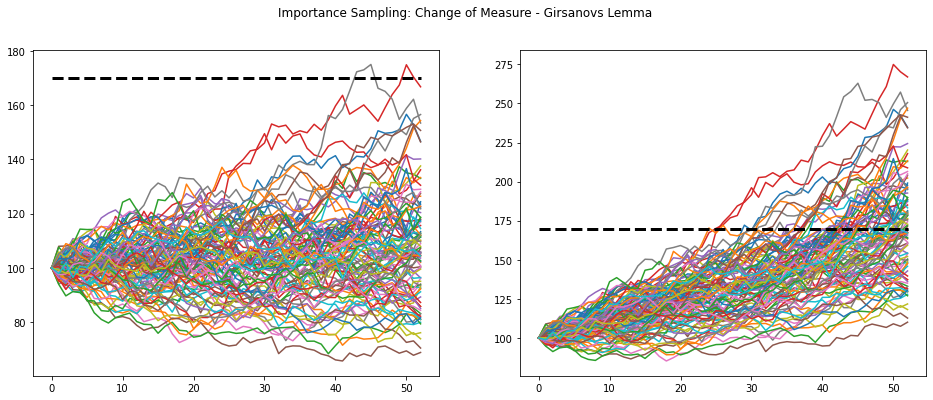

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
fig.suptitle('Importance Sampling: Change of Measure - Girsanovs Lemma')
ax1.plot(ST)
ax1.plot([0,N],[K,K],'k--',linewidth=3)

ax2.plot(ST2)
ax2.plot([0,N],[K,K],'k--',linewidth=3)

plt.show()

In [ ]:
print("Black Scholes Price: ", round(BS,4))

Black Scholes Price:  0.0789


In [ ]:
# Initialise parameters
S0 = 100.0     # initial stock price
K = 170.0      # strike price
T = 1.0        # time to maturity in years
r = 0.06       # annual risk-free rate
vol = 0.20     # volatility (%)

dt = T
nudt = (r - 0.5*vol**2)*dt
nudt2 = (np.log(K/S0)-0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)

nudt, nudt2

(0.039999999999999994, 0.5106282510621704)

### Choosing the correct distribution to minimize variance

$\large E[f(x)] = \int f(x)p(x) dx = \int f(x)\frac{p(x)}{q(x)}q(x) dx	\approx \frac{1}{n}\sum_i f(x_i)\frac{p(x)}{q(x)}$

$\large E_\mathbb{Q}[f(S_T)] = E_{\mathbb{Q}_{0}}[f(S_T) \frac{\mathbb{dQ}}{\mathbb{dQ}_{0}}]$

Unfortunately there is no general way to final the optimal $q(x)$ distribution under $\mathbb{dQ}_{0}$ distribution. But we can find the relatively optimal g to reduce variance.

$\Large min_\mu E_p \left[ f^2(x) \frac{p(x)}{q_\mu(x)} \right]$

<b>References</b>:
Variance Reduction Techniques of Importance Sampling Monte Carlo Methods for Pricing Options
Journal of Mathematical Finance, 2013, 3, 431-436
Published Online November 2013 (http://www.scirp.org/journal/jmf)
http://dx.doi.org/10.4236/jmf.2013.34045

In [ ]:
p = sc.stats.norm(nudt,volsdt)
q = lambda mu: sc.stats.norm(mu, volsdt)
z_T = lambda x, mu, sig: mu + sig*x
f_0 = lambda z: np.exp(-r*T)*np.maximum(0, S0*np.exp(z)-K)

M = 1000000
def arg_min(x):
    x_T = np.random.normal(0, 1, M)
    z = z_T(x_T,nudt,volsdt)
    return np.mean( f_0(z)**2 * p.pdf(z)/q(x).pdf(z) )

In [ ]:
mu_star = sc.optimize.fmin(lambda x: arg_min(x), nudt2, disp=True)
mu_star

array([0.63988103])

In [ ]:
C0_is, SE_is = [], []
for M in np.arange(100,1000+100,100):
    mu = mu_star[0]
    x = np.random.randn(M)
    z = z_T(x,mu,volsdt)
    CT = f_0(z) * p.pdf(z)/q(mu).pdf(z)
    C0 = np.mean( CT )

    sigma = np.sqrt( np.sum( (CT - C0)**2) / (M-1) )
    SE = sigma/np.sqrt(M)

    C0_is.append(C0)
    SE_is.append(SE)

C0_is = np.array(C0_is)
SE_is = np.array(SE_is)

print("Call value is ${0} with SE +/- {1}".format(np.round(C0_is,3),np.round(SE_is,3)))

Call value is $[0.073 0.083 0.085 0.072 0.079 0.078 0.076 0.079 0.076 0.074] with SE +/- [0.009 0.006 0.005 0.004 0.004 0.003 0.003 0.003 0.003 0.003]


In [ ]:
C0_wo, SE_wo = [], []
for M in np.arange(100,1000+100,100):
    x = np.random.randn(M)
    z = z_T(x, nudt, volsdt)
    CT = f_0(z)
    C0 = np.mean( CT )

    sigma = np.sqrt( np.sum( (CT - C0)**2) / (M-1) )
    SE = sigma/np.sqrt(M)
    C0_wo.append(C0)
    SE_wo.append(SE)

C0_wo = np.array(C0_wo)
SE_wo = np.array(SE_wo)

print("Call value is ${0} with SE +/- {1}".format(np.round(C0_wo,3),np.round(SE_wo,3)))

Call value is $[0.075 0.    0.098 0.121 0.018 0.15  0.022 0.055 0.01  0.174] with SE +/- [0.065 0.    0.068 0.089 0.018 0.092 0.022 0.033 0.01  0.079]


In [ ]:
SE_Ratio = SE_wo/SE_is

print("Standard Error Reduction Factor {0}".format(np.round(SE_Ratio,3)))

Standard Error Reduction Factor [ 7.652  0.    13.909 21.342  4.95  26.913  6.975 11.257  3.474 30.679]


In [ ]:
import pandas as pd

M = np.arange(100,1000+100,100)
prices = pd.DataFrame(np.array([M, C0_wo.round(3), C0_is.round(3), SE_wo.round(3), SE_is.round(3), SE_Ratio.round(1)]).T,
                      columns=['Simulations','Price_wo', 'Price_is','SE_wo', 'SE_is', 'Reduction'])

print("Black Scholes Price: ", round(BS,4))
prices

Black Scholes Price:  0.0789


,Simulations,Price_wo,Price_is,SE_wo,SE_is,Reduction
0,100.0,0.075,0.073,0.065,0.009,7.7
1,200.0,0.000,0.083,0.000,0.006,0.0
2,300.0,0.098,0.085,0.068,0.005,13.9
3,400.0,0.121,0.072,0.089,0.004,21.3
4,500.0,0.018,0.079,0.018,0.004,4.9
5,600.0,0.150,0.078,0.092,0.003,26.9
6,700.0,0.022,0.076,0.022,0.003,7.0
7,800.0,0.055,0.079,0.033,0.003,11.3
8,900.0,0.010,0.076,0.010,0.003,3.5
9,1000.0,0.174,0.074,0.079,0.003,30.7
